***Imports***

In [25]:
# Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import pickle


from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #Check if GPU is available before attempting any training. If not it will default at CPU.

Num GPUs Available:  1


***Read the data***

In [18]:
df = pd.read_csv('2018-06-06-ss.cleaned.csv') #Need to be downloaded from kaggle, see README.md
#df = pd.read_csv('protein-secondary-structure.test.csv')
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CBC,CEC,3,False
1,1B05,B,KCK,CBC,CEC,3,False
2,1B0H,B,KAK,CBC,CEC,3,False
3,1B1H,B,KFK,CBC,CEC,3,False
4,1B2H,B,KAK,CBC,CEC,3,False


***Clean dataset before training***

In [19]:
df.drop_duplicates() #remove duplicates if any in the dataset
df.dropna() #drop NaN values from the dataset if any
df.info() #analyse the columns and entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393732 entries, 0 to 393731
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   pdb_id         393732 non-null  object
 1   chain_code     393732 non-null  object
 2   seq            393732 non-null  object
 3   sst8           393732 non-null  object
 4   sst3           393732 non-null  object
 5   len            393732 non-null  int64 
 6   has_nonstd_aa  393732 non-null  bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 18.4+ MB


In [20]:
df = df.drop(columns=['sst8']) #Remove sst8 because we do not care about it, we only care about 'sst3' as explained in report.

df.head()

,pdb_id,chain_code,seq,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CEC,3,False
1,1B05,B,KCK,CEC,3,False
2,1B0H,B,KAK,CEC,3,False
3,1B1H,B,KFK,CEC,3,False
4,1B2H,B,KAK,CEC,3,False


In [21]:
#df = df.drop(df[df.has_nonstd_aa == True].index) #Test if has_nonstd_aa had any effect on the dataset. It had very little effect on the training so we kept it.
df.head()

,pdb_id,chain_code,seq,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CEC,3,False
1,1B05,B,KCK,CEC,3,False
2,1B0H,B,KAK,CEC,3,False
3,1B1H,B,KFK,CEC,3,False
4,1B2H,B,KAK,CEC,3,False


In [22]:
# NLP: Tokenization of the sequences
df['tokens'] = df['seq'].apply(lambda x: list(x)) #Split invidual characters into tokens
df['output'] = df['sst3'].apply(lambda x: list(x))
df.head()

,pdb_id,chain_code,seq,sst3,len,has_nonstd_aa,tokens,output
0,1A30,C,EDL,CEC,3,False,"[E, D, L]","[C, E, C]"
1,1B05,B,KCK,CEC,3,False,"[K, C, K]","[C, E, C]"
2,1B0H,B,KAK,CEC,3,False,"[K, A, K]","[C, E, C]"
3,1B1H,B,KFK,CEC,3,False,"[K, F, K]","[C, E, C]"
4,1B2H,B,KAK,CEC,3,False,"[K, A, K]","[C, E, C]"


***Exploratory Data Analysis***

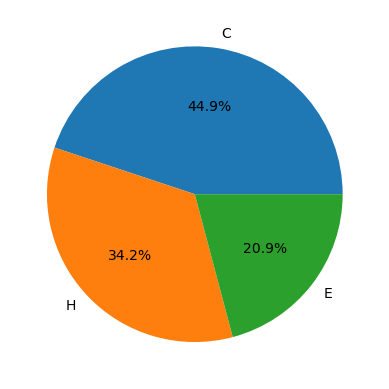

In [23]:
#Exploratory Data Analysis


fdist = FreqDist() #Frequency dictionary

for row in df['output']:
    for word in row:
        fdist[word] += 1 #update counts for each of the three letters

counts = fdist.most_common(3)

letters = []
numbers = []
for index, total in counts: #split into x,y to plot 
    letters.append(index)
    numbers.append(total)

#Source: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
plt.pie(numbers, labels = letters, autopct='%1.1f%%')
plt.show()


***The pie plot shows the percentage of the different secondary structures in the dataset. C: Random coil, H: Alpha Helix, E: Beta sheet***

In [26]:

dict = Dictionary(df['tokens']) #create a dictionary of all the tokens

freq_dist = {}

for index, label in dict.items(): #loop through label by label

    label_freq = FreqDist() #unique frequency distribution for each label

    for input, output in zip(df['tokens'], df['output']): #source: https://www.geeksforgeeks.org/python-iterate-multiple-lists-simultaneously/
       for i_w, o_w in zip(input, output): #input_word, output_word
            if i_w == label: #only add corresponding output for correct label
                label_freq[o_w] += 1

    freq_dist[label] = label_freq

print(freq_dist)




{'D': FreqDist({'C': 3356470, 'H': 1728160, 'E': 669723}), 'E': FreqDist({'H': 3088575, 'C': 2718594, 'E': 949640}), 'L': FreqDist({'H': 4166473, 'C': 2860364, 'E': 2180552}), 'C': FreqDist({'C': 557813, 'E': 418981, 'H': 403975}), 'K': FreqDist({'C': 2744823, 'H': 2276480, 'E': 1010515}), 'A': FreqDist({'H': 3879174, 'C': 2987202, 'E': 1316352}), 'F': FreqDist({'H': 1413603, 'C': 1376651, 'E': 1198403}), 'M': FreqDist({'H': 977608, 'C': 943440, 'E': 476042}), 'H': FreqDist({'C': 1509529, 'H': 748245, 'E': 488329}), 'I': FreqDist({'H': 2132664, 'E': 2039454, 'C': 1558918}), 'G': FreqDist({'C': 5253884, 'H': 1269434, 'E': 1059849}), 'P': FreqDist({'C': 3477788, 'H': 841721, 'E': 432939}), 'S': FreqDist({'C': 3575886, 'H': 1707737, 'E': 1158266}), 'T': FreqDist({'C': 2738101, 'H': 1501836, 'E': 1466144}), 'Y': FreqDist({'C': 1220064, 'H': 1198840, 'E': 1087819}), 'N': FreqDist({'C': 2565935, 'H': 1142094, 'E': 572572}), 'Q': FreqDist({'H': 1620933, 'C': 1596983, 'E': 642412}), 'V': FreqD

In [29]:
#Function to retrieve pieplot for individual amino acids. Do not change.

def label_freq_dist(token):

    ## check if token is valid
    if token in freq_dist:
        token_freq = freq_dist[token] 
    else:
        return "Not valid token"

    indexes = []
    values = []
    for idx, value in token_freq.items():
        indexes.append(idx)
        values.append(value)
    plt.pie(values, labels=indexes, autopct='%1.1f%%') #show pie chart
    plt.show()
    return token_freq.items() #return numbers for user 



***Edit the amino acids in the parameter below to show the pie plot for a chosen amino acid.***

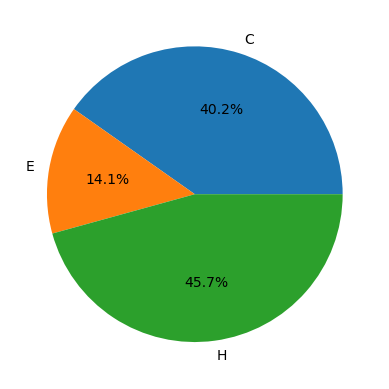

dict_items([('C', 2718594), ('E', 949640), ('H', 3088575)])

In [36]:
label_freq_dist('E')

***Padding to ensure all sequences is the similar length before sending it to the model***

In [8]:
#Padding to get uniform length and encoding characters

#Source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer


# tokenizer = Tokenizer(char_level=True) #Tokenizer from character to integer
# tokenizer.fit_on_texts(df['tokens']) #Train tokenizer on text/list to only tokenize amino acids in dictionary.

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

df['tokens_int'] = tokenizer.texts_to_sequences(df['tokens']) #Convert list to encoded integers

output_mapping = {'C': 1, 'H': 2, 'E': 3} #Output mapped to integers
df['outputs_int'] = df['output'].apply(lambda x: [output_mapping[label] for label in x]) #apply the mapping to the outputs



#max_length = df['len'].max() #max length according to dataset
max_length = 5037 # Force max length to the one used for training



#Pad input tokens by adding 0 to match the maximum length in the dataset. (5037) 
padded_tokens = pad_sequences(df['tokens_int'].to_list(), maxlen=max_length, padding='post', value=0)
padded_outputs = pad_sequences(df['outputs_int'].to_list(), maxlen=max_length, padding='post', value=0)


print(max_length)
assert len(padded_tokens[0]) == max_length
assert len(padded_outputs[0]) == max_length #ensure padding is done correctly




5037


***Segment for exporting the tokenizer, to use it in the executable file***

In [9]:
import pickle

df.head()

# saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

,pdb_id,chain_code,seq,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue,tokens,output,tokens_int,outputs_int
0,NaN,NaN,ENLKLGFLVKQPEEPWFQTEWKFADKAGKDLGFEVIKIAVPDGEKT...,CCCCCCEEECCCCCCCHHHHHHHHHHHHHHCCCCCCEEECCCHHHH...,306,NaN,NaN,NaN,NaN,NaN,"[E, N, L, K, L, G, F, L, V, K, Q, P, E, E, P, ...","[C, C, C, C, C, C, E, E, E, C, C, C, C, C, C, ...","[5, 13, 1, 7, 1, 3, 14, 1, 4, 7, 15, 12, 5, 5,...","[1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, ..."
1,NaN,NaN,APAFSVSPASGASDGQSVSVSVAAAGETYYIAQCAPVGGQDACNPA...,CCEEEEECCCCCCCCCEEEEEEECCCCEEEEEEECEECCEECCCCC...,108,NaN,NaN,NaN,NaN,NaN,"[A, P, A, F, S, V, S, P, A, S, G, A, S, D, G, ...","[C, C, E, E, E, E, E, C, C, C, C, C, C, C, C, ...","[2, 12, 2, 14, 6, 4, 6, 12, 2, 6, 3, 2, 6, 8, ...","[1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,NaN,NaN,GFPIPDPYCWDISFRTFYTIVDDEHKTLFNGILLLSQADNADHLNE...,CCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHCCCHHHHHH...,113,NaN,NaN,NaN,NaN,NaN,"[G, F, P, I, P, D, P, Y, C, W, D, I, S, F, R, ...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[3, 14, 12, 9, 12, 8, 12, 16, 19, 20, 8, 9, 6,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,NaN,NaN,RDFTPPTVKILQSSCDGGGHFPPTIQLLCLVSGYTPGTINITWLED...,CCCCCCEEEEECCCCCCCCCCCCEEEEEEEEEEECCCCCEEEEECC...,322,NaN,NaN,NaN,NaN,NaN,"[R, D, F, T, P, P, T, V, K, I, L, Q, S, S, C, ...","[C, C, C, C, C, C, E, E, E, E, E, C, C, C, C, ...","[11, 8, 14, 10, 12, 12, 10, 4, 7, 9, 1, 15, 6,...","[1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, ..."
4,NaN,NaN,RICFNQHSSQPQTTKTCSPGESSCYHKQWSDFRGTIIERGCGCPTV...,CEEECCCCCCCCCEEECCCCCCCEEEEEEEECCEEEEEEEECCCCC...,62,NaN,NaN,NaN,NaN,NaN,"[R, I, C, F, N, Q, H, S, S, Q, P, Q, T, T, K, ...","[C, E, E, E, C, C, C, C, C, C, C, C, C, E, E, ...","[11, 9, 19, 14, 13, 15, 17, 6, 6, 15, 12, 15, ...","[1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, ..."


***Segment for creating the model, before training. It is commented out as it is not advisable to do the training unless you PC has a graphics card like NVIDIA RTX 3080. The training takes approx. 6 hours.***
***The model we trained is imported further down, and can be used***

In [ ]:

# print(tf.version.VERSION)

# #Very simple LSTM model


# model = Sequential()
# model.add(Embedding(input_dim=len(freq_dist)+1, output_dim=64, mask_zero = True))
# model.add(Bidirectional(GRU(units=200, return_sequences=True)))
# model.add(Dropout(0.75, noise_shape=None, seed=None))
# model.add(Bidirectional(GRU(units=200, return_sequences=True)))
# # model.add(Dropout(0.2, noise_shape=None, seed=None))
# # model.add(Bidirectional(GRU(units=50, return_sequences=True)))
# # model.add(Dropout(0.2, noise_shape=None, seed=None))
# #model.add(Bidirectional(GRU(units=20, return_sequences=True)))
# model.add(TimeDistributed(Dense(4, activation='softmax')))

# stop_callback = EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.001,
#     patience=2,
# )


# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])


***Split data into training and test data set, the function is imported from scikit-learn and randomly shuffles data data into a data set and a test set, to both train and do validation on.***

In [ ]:
#Split data into Train and Test split:

#X_train, X_test, y_train, y_test = train_test_split(padded_tokens, padded_outputs, test_size=0.25, random_state=42)



In [ ]:

#print(len(X_train))
#print(len(X_test))

***Segment for training the dataset, It is commented out as it is not advisable to do the training unless you PC has a graphics card like NVIDIA RTX 3080. The training takes approx. 6 hours.***

In [ ]:
# train_model = model.fit(X_train, y_train, batch_size=None, epochs=40, callbacks=stop_callback, validation_data=(X_test, y_test))

***The tests performance, can only be ran if the data is trained. Our model gave us an accuracy of 0.84 on the test data set of unseen data.***

In [ ]:
# results = model.evaluate(X_test, y_test, batch_size=None)
# print("test loss, test acc:", results)

***Import the model we trained:***

In [10]:
loaded_model = tf.keras.models.load_model('trained_model.keras')

***Evaluation of the loaded model:***

In [11]:
results = loaded_model.evaluate(padded_tokens, padded_outputs, batch_size=None)
print("test loss, test acc:", results)

1/1 [==============================] - 6s 6s/step - loss: 0.0234 - accuracy: 0.7952
test loss, test acc: [0.023411529138684273, 0.7951704263687134]


***Functions to display the prediction. Includes removal of padding, decoding and visual coloring of the correct/missed predictions made.***

In [12]:
def remove_padding(prediction, answer):

    answer_indexes =  np.where(answer != 0)

    pred = prediction[answer_indexes]
    ans = answer[answer_indexes]

    assert len(pred) == len(ans)

    return pred, ans 

In [13]:
def decode_prediction(pred, ans):
    
    reversed_mapping = {1: 'C', 2: 'H', 3: 'E'}
    
    decode_pred = [reversed_mapping[label] for label in pred]
    decode_ans = [reversed_mapping[label] for label in ans]
    
    return decode_pred, decode_ans

In [14]:
#DISCLAIMER: The color_compare and color_true_answer functions is partly generated from ChatGPT: https://chat.openai.com/
#The code is only used for easier visibility when comparing predictions with the answer and has no effect on the prediction or performance of the model.
#The code uses ANSI escape code to change the visible text color.
def color_compare(pred, ans):
    correct = 0
    print("Prediction: ")
    for a, b in zip(pred, ans):
        if a == b:
            print(f"\033[92m{a}\033[0m", end=' ')  # Green for match
            correct += 1
        else:
            print(f"\033[91m{a}\033[0m", end=' ')  # Red for mismatch
    print()
    return correct/len(ans)  # Return 

def color_true_answer(pred, ans):
    count = 0
    print("True answer: ")
    for a, b in zip(pred, ans):
        if a != b:
            print(f"\033[91m{b}\033[0m", end=' ')  # Red for mismatch
            count += 1
        else:
            print(f"{b}", end=' ')  # Default color for match
    print()  # Newline at the end
    return count

***Predictions made on the dataset: y_test and X_test needs to have similar indexes.***

***Including classification report with precision, f1-score and recall for all the different classes***

In [15]:
from sklearn.metrics import classification_report

#Because classification report and confusion matrix does not support multi-class multi-output we need to use an alternate way
#Creates two empty lists to collect data about every single prediction made
all_predictions = []
all_answer = []

prediction_input = padded_tokens
prediction_answers = padded_outputs

prediction = loaded_model.predict(prediction_input)  
prediction = np.argmax(prediction, axis=-1)

for x, y in zip(prediction, prediction_answers):
    pred, ans = remove_padding(x, y)
    pred, ans = decode_prediction(pred, ans)

    all_predictions.extend(pred)
    all_answer.extend(ans)

    accuracy = color_compare(pred, ans)
    mismatches = color_true_answer(pred, ans)

    print("The accuracy is:", accuracy)
    print("The total number of mismatches is:", mismatches, "out of", len(ans))
    print() #Newline



1/1 [==============================] - 4s 4s/step
Prediction: 
C C C E E E E E E C C C C C H H H H H H H H H H H H H H H H H C C E E E E E E C C C C H H H H H H H H H H H H C C C C E E E E E C C C H H H H H H H H H H H H C C C E E E E E E E C C E E C C C C C C C C C C C E E E E E C C C C C H H H H H H H H H H H H H C C C C C C E E E E E E E C C C H H H H H H H H C C H H H H H H H H C C C C H H H E E E E C C C H H H H H H H H H H H H H H H H H C C C C C E E E E E E C C H H H H H H H H H H H H H C C C C C C C E E E E E E C C H H H H H H H H C C C C C E E E E C C C C C C C C C C C C H H H H H H H H H H H C C C C C C E E E E C C E E E E C H H H H H H H H H H C C C C C C 
True answer: 
C C C C C C E E E C C C C C C C H H H H H H H H H H H H H H C C C C C C E E E C C C H H H H H H H H H H H H H C C C C C C C C C C C C C C C C C H H H H H H H H H C C C C C C C C C C C C C C C C C C C C C C C C C C C C C H H H H H H H H H H H H H H H H H H C C C C C C C C E E E C C C C C C C C C H H H H H H H 

***Classification report and confusion matrix***

In [16]:
print("Classification report: ")
print(classification_report(all_answer, all_predictions))

Classification report: 
              precision    recall  f1-score   support

           C       0.87      0.74      0.80      1923
           E       0.68      0.84      0.75       748
           H       0.77      0.88      0.82       849

    accuracy                           0.80      3520
   macro avg       0.78      0.82      0.79      3520
weighted avg       0.81      0.80      0.80      3520



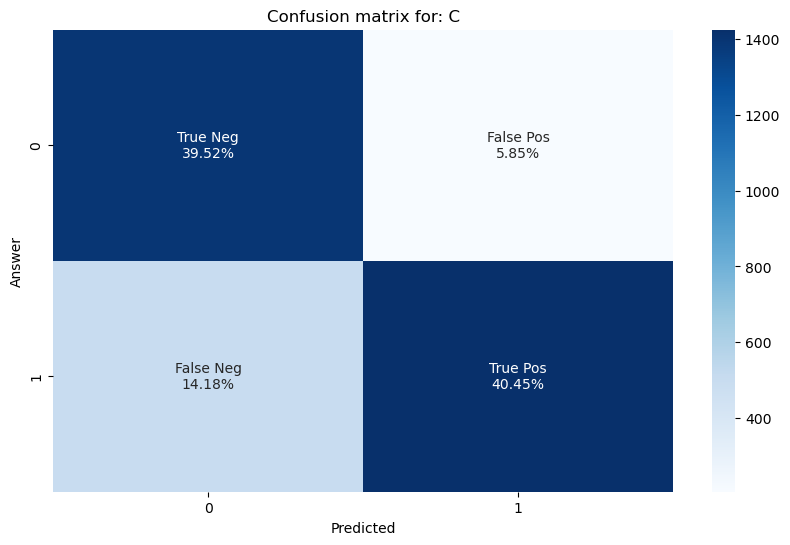

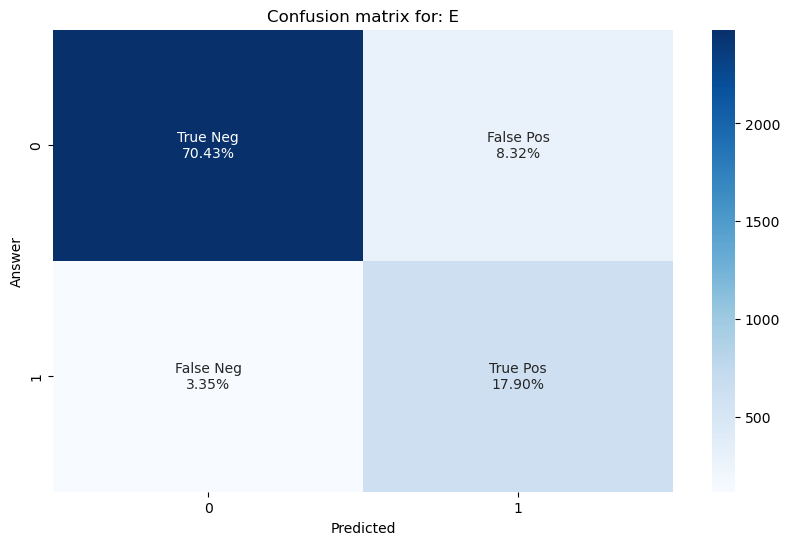

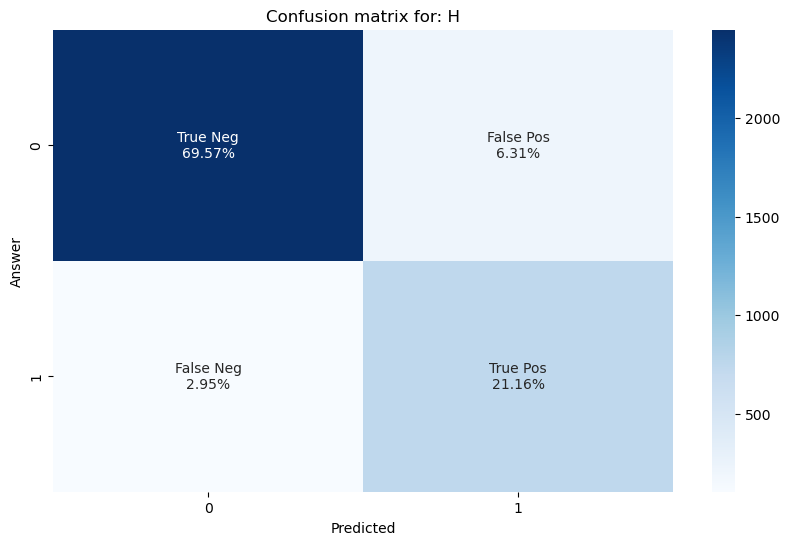

In [17]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

matrixes = multilabel_confusion_matrix(all_answer, all_predictions) #one confusion matrix for each of C, E, H

class_labels = ['C', 'E', 'H']
for i, matrix in enumerate(matrixes):
    percentage_dist = (matrix / matrix.sum())*100 #Creates a distribution of the percentages of counts in the different labels.
    labels = [[f"True Neg\n{percentage_dist[0,0]:.2f}%", f'False Pos\n{percentage_dist[0,1]:.2f}%'], [f'False Neg\n{percentage_dist[1,0]:.2f}%', f'True Pos\n{percentage_dist[1,1]:.2f}%']]
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    plt.title(f"Confusion matrix for: {class_labels[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("Answer")
    plt.show()


***Everything below is how to preprocess the data in order to use this model to make predictions on other datasets.***

In [11]:
df_test = pd.read_csv('protein-secondary-structure.test.csv')
df_test.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue
0,NaN,NaN,ENLKLGFLVKQPEEPWFQTEWKFADKAGKDLGFEVIKIAVPDGEKT...,NaN,CCCCCCEEECCCCCCCHHHHHHHHHHHHHHCCCCCCEEECCCHHHH...,306,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,APAFSVSPASGASDGQSVSVSVAAAGETYYIAQCAPVGGQDACNPA...,NaN,CCEEEEECCCCCCCCCEEEEEEECCCCEEEEEEECEECCEECCCCC...,108,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,GFPIPDPYCWDISFRTFYTIVDDEHKTLFNGILLLSQADNADHLNE...,NaN,CCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHCCCHHHHHH...,113,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,RDFTPPTVKILQSSCDGGGHFPPTIQLLCLVSGYTPGTINITWLED...,NaN,CCCCCCEEEEECCCCCCCCCCCCEEEEEEEEEEECCCCCEEEEECC...,322,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,RICFNQHSSQPQTTKTCSPGESSCYHKQWSDFRGTIIERGCGCPTV...,NaN,CEEECCCCCCCCCEEECCCCCCCEEEEEEEECCEEEEEEEECCCCC...,62,NaN,NaN,NaN,NaN,NaN


In [12]:
df_test.drop_duplicates() #remove duplicates if any in the dataset
df_test.dropna() #drop NaN values from the dataset if any
df_test.info() #analyse the columns and entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         0 non-null      float64
 1   chain_code     0 non-null      float64
 2   seq            15 non-null     object 
 3   sst8           0 non-null      float64
 4   sst3           15 non-null     object 
 5   len            15 non-null     int64  
 6   has_nonstd_aa  0 non-null      float64
 7   Exptl.         0 non-null      float64
 8   resolution     0 non-null      float64
 9   R-factor       0 non-null      float64
 10  FreeRvalue     0 non-null      float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.4+ KB


In [13]:
df_test = df_test.drop(columns=['sst8', 'has_nonstd_aa', 'Exptl.', 'resolution', 'R-factor', 'FreeRvalue']) #Remove sst8 because we do not care about it, we look at sst3.
df_test['tokens'] = df_test['seq'].apply(lambda x: list(x)) #Split invidual characters into tokens
df_test['output'] = df_test['sst3'].apply(lambda x: list(x))

df_test['tokens_int'] = tokenizer.texts_to_sequences(df_test['tokens']) #Convert list to encoded integers

output_mapping = {'C': 1, 'H': 2, 'E': 3} #Mapped to high numbers to efficiently differentiate with the amino acids
df_test['outputs_int'] = df_test['output'].apply(lambda x: [output_mapping[label] for label in x])

df_test.head()


,pdb_id,chain_code,seq,sst3,len,tokens,output,tokens_int,outputs_int
0,NaN,NaN,ENLKLGFLVKQPEEPWFQTEWKFADKAGKDLGFEVIKIAVPDGEKT...,CCCCCCEEECCCCCCCHHHHHHHHHHHHHHCCCCCCEEECCCHHHH...,306,"[E, N, L, K, L, G, F, L, V, K, Q, P, E, E, P, ...","[C, C, C, C, C, C, E, E, E, C, C, C, C, C, C, ...","[5, 13, 1, 7, 1, 3, 14, 1, 4, 7, 15, 12, 5, 5,...","[1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, ..."
1,NaN,NaN,APAFSVSPASGASDGQSVSVSVAAAGETYYIAQCAPVGGQDACNPA...,CCEEEEECCCCCCCCCEEEEEEECCCCEEEEEEECEECCEECCCCC...,108,"[A, P, A, F, S, V, S, P, A, S, G, A, S, D, G, ...","[C, C, E, E, E, E, E, C, C, C, C, C, C, C, C, ...","[2, 12, 2, 14, 6, 4, 6, 12, 2, 6, 3, 2, 6, 8, ...","[1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,NaN,NaN,GFPIPDPYCWDISFRTFYTIVDDEHKTLFNGILLLSQADNADHLNE...,CCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHCCCHHHHHH...,113,"[G, F, P, I, P, D, P, Y, C, W, D, I, S, F, R, ...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[3, 14, 12, 9, 12, 8, 12, 16, 19, 20, 8, 9, 6,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,NaN,NaN,RDFTPPTVKILQSSCDGGGHFPPTIQLLCLVSGYTPGTINITWLED...,CCCCCCEEEEECCCCCCCCCCCCEEEEEEEEEEECCCCCEEEEECC...,322,"[R, D, F, T, P, P, T, V, K, I, L, Q, S, S, C, ...","[C, C, C, C, C, C, E, E, E, E, E, C, C, C, C, ...","[11, 8, 14, 10, 12, 12, 10, 4, 7, 9, 1, 15, 6,...","[1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, ..."
4,NaN,NaN,RICFNQHSSQPQTTKTCSPGESSCYHKQWSDFRGTIIERGCGCPTV...,CEEECCCCCCCCCEEECCCCCCCEEEEEEEECCEEEEEEEECCCCC...,62,"[R, I, C, F, N, Q, H, S, S, Q, P, Q, T, T, K, ...","[C, E, E, E, C, C, C, C, C, C, C, C, C, E, E, ...","[11, 9, 19, 14, 13, 15, 17, 6, 6, 15, 12, 15, ...","[1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, ..."


In [14]:
padded_tokens_test = pad_sequences(df_test['tokens_int'].to_list(), maxlen=max_length, padding='post', value=0)
padded_outputs_test = pad_sequences(df_test['outputs_int'].to_list(), maxlen=max_length, padding='post', value=0)

results = loaded_model.evaluate(padded_tokens_test, padded_outputs_test, batch_size=None)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 107ms/step - loss: 0.0234 - accuracy: 0.7952
test loss, test acc: [0.023411529138684273, 0.7951704263687134]


In [ ]:
# model.save("trained_model.keras")

# dict = Dictionary(df['tokens'])
# corpus = [dict.doc2bow(row) for row in df['tokens']]

# model = TfidfModel(corpus)
# vector = model[corpus[0]]
# for id, score in vector:
#     token = dict[id]
#     print(token, score)




In [ ]:

# le = LabelEncoder()
# y = le.fit_transform(df['sst3'])

# X_train, X_test, y_train, y_test = train_test_split(model[corpus], y, test_size=0.3, random_state=42)